In [2]:
import pandas as pd

# Load the data
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')


In [3]:
# Merge customer and transaction data on CustomerID
merged_df = pd.merge(customers_df, transactions_df, on='CustomerID')


In [4]:
# Check for missing values
merged_df.isnull().sum()

# Optionally fill missing values or drop rows
merged_df.fillna(0, inplace=True)  # Or use mean/median for numeric columns


In [5]:
# Convert TransactionDate to datetime format
merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'])

# Aggregate transaction data by CustomerID
agg_df = merged_df.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    avg_transaction_value=('Price', 'mean'),
    num_transactions=('TransactionID', 'count'),
    # Calculate transaction frequency based on unique transaction dates
    transaction_frequency=('TransactionDate', lambda x: (x.max() - x.min()).days / len(x.unique()) if len(x.unique()) > 1 else 0),
    # Calculate recency as the days since the most recent transaction
    recency=('TransactionDate', lambda x: (pd.to_datetime('today') - x.max()).days)
).reset_index()

agg_df.head()


,CustomerID,total_spent,avg_transaction_value,num_transactions,transaction_frequency,recency
0,C0001,3354.52,278.334000,5,57.600000,85
1,C0002,1862.74,208.920000,4,69.500000,55
2,C0003,2725.38,195.707500,4,47.000000,155
3,C0004,5354.88,240.636250,8,37.375000,34
4,C0005,2034.24,291.603333,3,77.666667,84


In [73]:
from sklearn.preprocessing import StandardScaler

# Select the features for clustering
features = ['total_spent', 'avg_transaction_value', 'num_transactions', 'transaction_frequency', 'recency']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(agg_df[features])



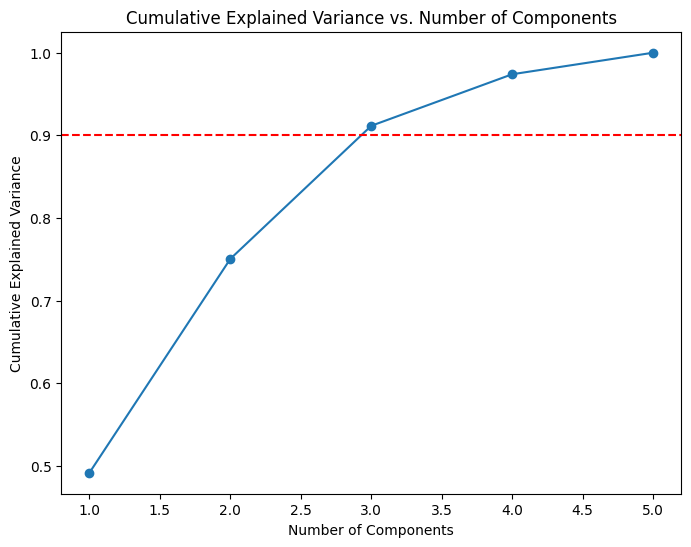

In [74]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA and capture the explained variance ratio
pca = PCA()
pca.fit(scaled_features)

# Plot the cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='--')  # Mark 90% variance
plt.show()


# KMEANS CLUSTERING

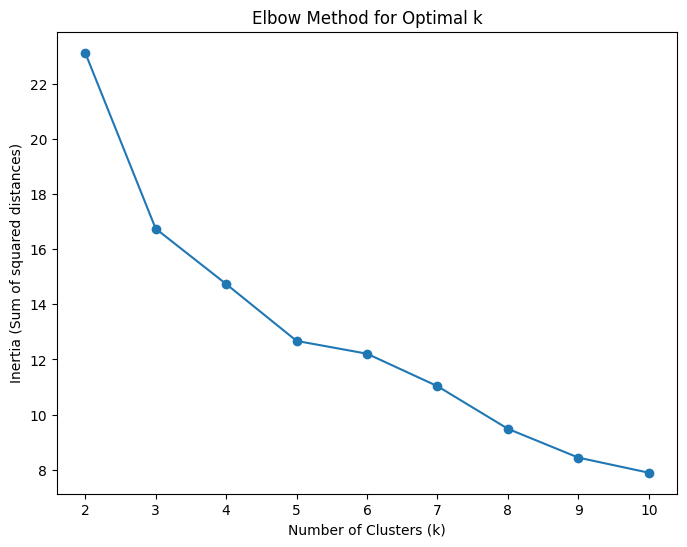

In [75]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculate the inertia (sum of squared distances)
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.show()


In [76]:
# Choose k based on the Elbow method
k = 3      # Example, choose the k from the Elbow method
# Apply KMeans clustering with K-Means++ initialization
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)

# Fit the model and predict the clusters
agg_df['Cluster'] = kmeans.fit_predict(scaled_features)
agg_df.head()


,CustomerID,total_spent,avg_transaction_value,num_transactions,transaction_frequency,recency,Cluster,DBSCAN_Cluster,Agglomerative_Cluster
0,C0001,3354.52,278.334000,5,57.600000,85,1,-1,0
1,C0002,1862.74,208.920000,4,69.500000,55,1,-1,0
2,C0003,2725.38,195.707500,4,47.000000,155,1,-1,0
3,C0004,5354.88,240.636250,8,37.375000,34,0,-1,1
4,C0005,2034.24,291.603333,3,77.666667,84,1,-1,0


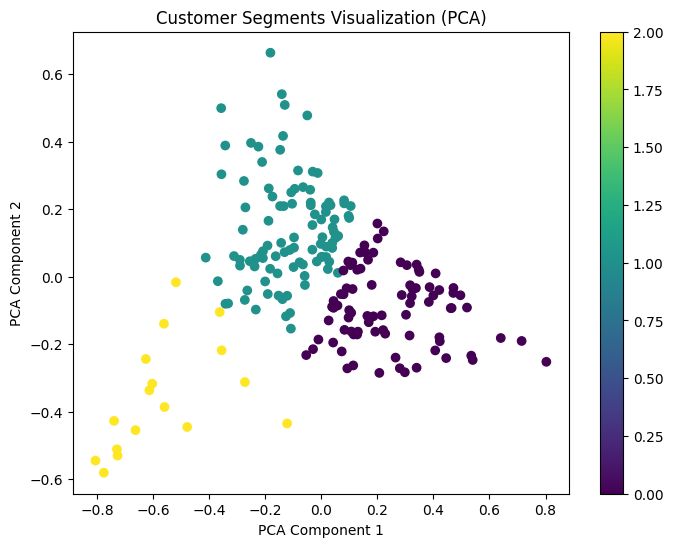

In [77]:
from sklearn.decomposition import PCA

# Reduce the feature space to 2D for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=agg_df['Cluster'], cmap='viridis')
plt.title('Customer Segments Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()


In [78]:
# Group by clusters and summarize the features
cluster_summary = agg_df.groupby('Cluster').agg({
    'total_spent': ['mean', 'std'],
    'avg_transaction_value': ['mean', 'std'],
    'num_transactions': ['mean', 'std'],
    'transaction_frequency': ['mean', 'std'],
    'recency': ['mean', 'std']
}).reset_index()

print(cluster_summary)


  Cluster  total_spent              avg_transaction_value             \
                  mean          std                  mean        std   
0       0  5073.389048  1386.410780            282.166340  53.240825   
1       1  2486.628367   913.709972            269.474395  75.151867   
2       2  1184.782353  1250.222959            233.445059  94.767597   

  num_transactions           transaction_frequency                recency  \
              mean       std                  mean        std        mean   
0         7.011905  1.500956             37.553701   9.872413   86.809524   
1         3.877551  1.067469             60.740816  23.627440   89.357143   
2         1.823529  1.236694              9.299020  17.772019  272.176471   

              
         std  
0  42.989345  
1  47.370279  
2  78.567833  


In [79]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Calculate Silhouette Score
sil_score = silhouette_score(scaled_features, kmeans.labels_)
print(f'Silhouette Score: {sil_score}')

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
print(f'Davies-Bouldin Index: {db_index}')


Silhouette Score: 0.3033390556078784
Davies-Bouldin Index: 1.1174390462540476


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


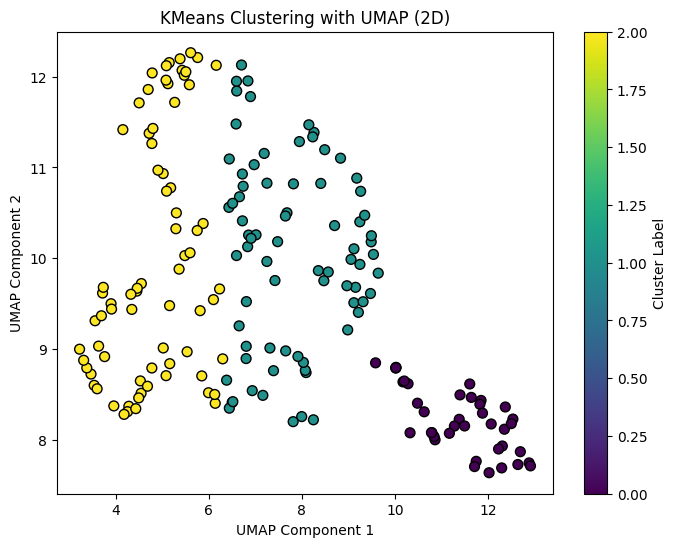

KMeans with UMAP Silhouette Score: 0.4415263831615448
KMeans with UMAP Davies-Bouldin Index: 0.8291237954998675


In [147]:
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Step 1: Preprocess the data (Scaling, Imputation, Outlier Removal)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(agg_df[features])  # Replace with your actual feature columns

# Step 2: Remove outliers using Z-score
z_scores = np.abs(zscore(scaled_features))
scaled_features_no_outliers = scaled_features[(z_scores < 3).all(axis=1)]  # Remove outliers based on Z-scores

# Step 3: Dimensionality Reduction using UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_components = umap_model.fit_transform(scaled_features_no_outliers)

# Step 4: Apply KMeans Clustering
n_clusters = 3  # Adjust this based on Silhouette Score or DBI
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(umap_components)

# Step 5: Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(umap_components[:, 0], umap_components[:, 1], c=kmeans_labels, cmap='viridis', edgecolor='k', s=50)
plt.title('KMeans Clustering with UMAP (2D)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Step 6: Evaluate Clustering (Silhouette Score and DBI)
sil_score_kmeans = silhouette_score(umap_components, kmeans_labels)
db_index_kmeans = davies_bouldin_score(umap_components, kmeans_labels)

print(f"KMeans with UMAP Silhouette Score: {sil_score_kmeans}")
print(f"KMeans with UMAP Davies-Bouldin Index: {db_index_kmeans}")


# DBSCAN CLUSTERING

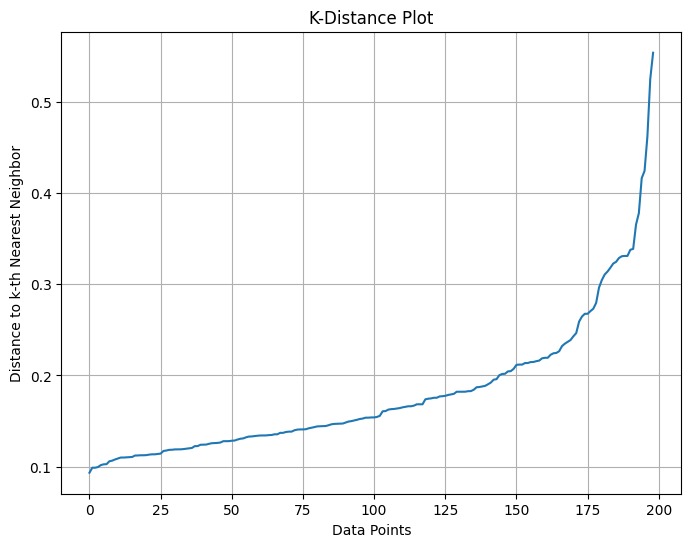

In [80]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Compute distances to the k-th nearest neighbor
k = 5  # Use min_samples value here
nbrs = NearestNeighbors(n_neighbors=k).fit(scaled_features)
distances, _ = nbrs.kneighbors(scaled_features)

# Sort distances and plot
distances = np.sort(distances[:, -1])  # k-th nearest distance
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title('K-Distance Plot')
plt.xlabel('Data Points')
plt.ylabel('Distance to k-th Nearest Neighbor')
plt.grid()
plt.show()


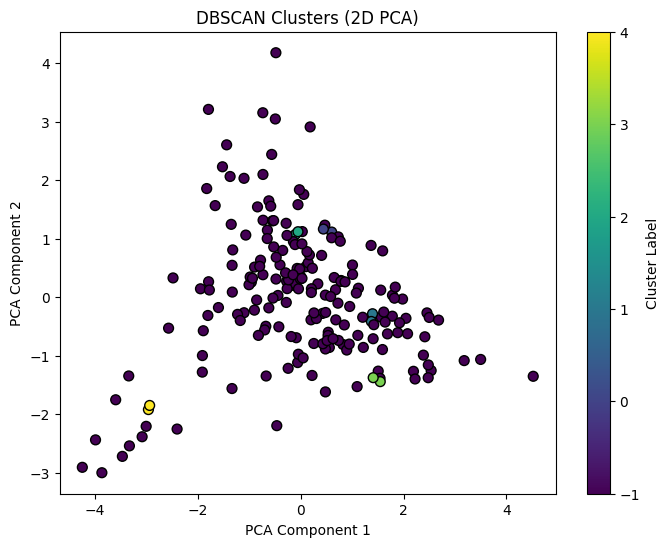

DBSCAN_Cluster
-1    189
 0      2
 1      2
 2      2
 3      2
 4      2
Name: count, dtype: int64


In [154]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Select the features for clustering
features = ['total_spent', 'avg_transaction_value', 'num_transactions', 'transaction_frequency', 'recency']
scaler = StandardScaler()

# Standardize the selected features
scaled_features = scaler.fit_transform(agg_df[features])

# Try different eps and min_samples values
dbscan = DBSCAN(eps=0.23, min_samples=2)  # Adjust eps and min_samples for better results
agg_df['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_features)

# Plot the clusters using PCA (2D projection)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=agg_df['DBSCAN_Cluster'], cmap='viridis', edgecolor='k', s=50)
plt.title('DBSCAN Clusters (2D PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Print the distribution of clusters
print(agg_df['DBSCAN_Cluster'].value_counts())

In [82]:
from sklearn.metrics import silhouette_score

# Exclude outliers (where label == -1)
valid_clusters = agg_df[agg_df['DBSCAN_Cluster'] != -1]

# Calculate the silhouette score
sil_score_dbscan = silhouette_score(scaled_features[valid_clusters.index], valid_clusters['DBSCAN_Cluster'])
print(f'DBSCAN Silhouette Score: {sil_score_dbscan}')


DBSCAN Silhouette Score: 0.8872411441863021


In [83]:
from sklearn.metrics import davies_bouldin_score

# Apply DBSCAN (assuming scaled_features is already prepared)
dbscan = DBSCAN(eps=0.3, min_samples=2)
dbscan_labels = dbscan.fit_predict(scaled_features)

# Check if at least two clusters exist (DB Index requires at least 2 clusters)
if len(set(dbscan_labels) - {-1}) > 1:  # Exclude outliers (-1)
    db_index_dbscan = davies_bouldin_score(scaled_features[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"DBSCAN Davies-Bouldin Index: {db_index_dbscan}")
else:
    print("DBSCAN did not form enough clusters for DB Index calculation.")


DBSCAN Davies-Bouldin Index: 0.23800836901418052


## GMM CLUSTERING

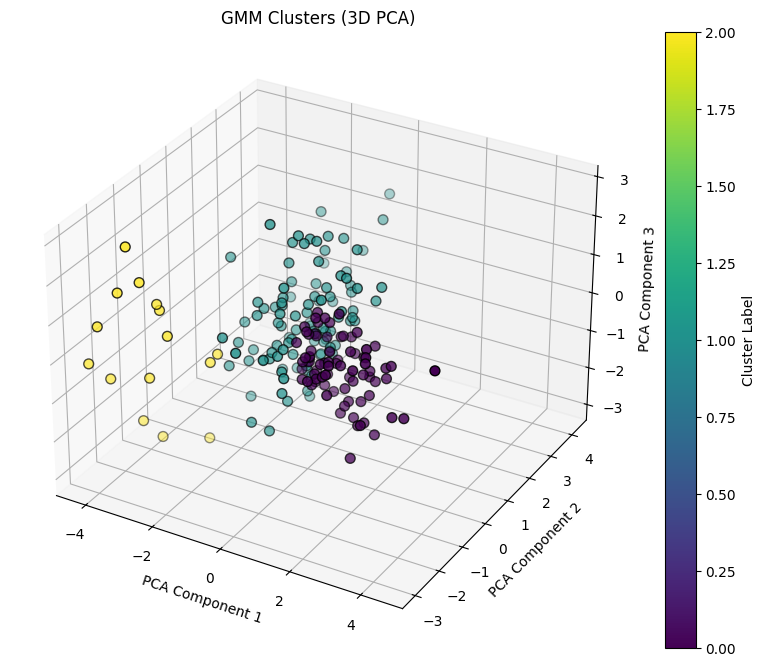

GMM Silhouette Score: 0.2596830327730122


In [153]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA and reduce to 3 components
pca = PCA(n_components=3)
pca_components = pca.fit_transform(scaled_features)

# Fit the GMM model with 3 components (clusters)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(pca_components)

# Add the cluster labels to the dataframe
agg_df['GMM_Cluster'] = gmm_labels

# Plot the clusters in 3D using the PCA components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the clusters
sc = ax.scatter(pca_components[:, 0], pca_components[:, 1], pca_components[:, 2], c=gmm_labels, cmap='viridis', edgecolor='k', s=50)
ax.set_title('GMM Clusters (3D PCA)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Display colorbar to indicate cluster labels
fig.colorbar(sc, label='Cluster Label')

plt.show()

# Calculate Silhouette Score for clustering evaluation
from sklearn.metrics import silhouette_score
sil_score_gmm = silhouette_score(pca_components, gmm_labels)
print(f'GMM Silhouette Score: {sil_score_gmm}')


In [187]:
# Apply GMM (assuming scaled_features is already prepared)
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(scaled_features)

# Calculate the DB Index
db_index_gmm = davies_bouldin_score(scaled_features, gmm_labels)
print(f"GMM Davies-Bouldin Index: {db_index_gmm}")


GMM Davies-Bouldin Index: 1.3985811215848345


# SPECTERAL CLUSTERING

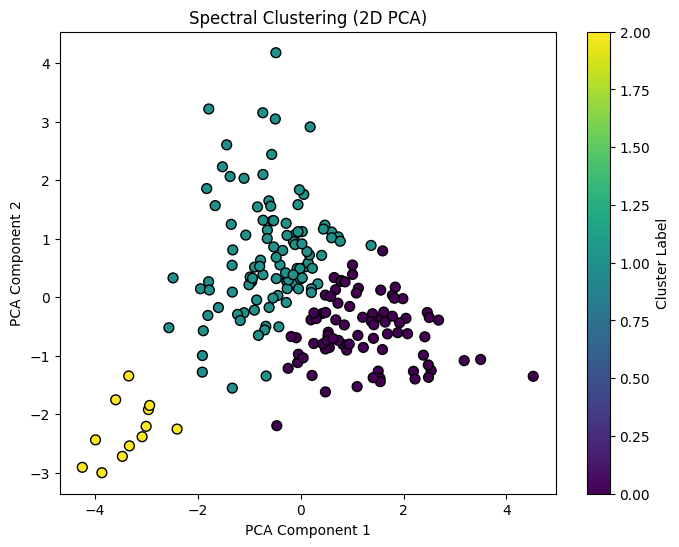

In [188]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Step 3: Apply Spectral Clustering
n_clusters = 3  # Choose the number of clusters
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42, assign_labels='kmeans')
spectral_labels = spectral.fit_predict(pca_components)

# Step 4: Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=spectral_labels, cmap='viridis', edgecolor='k', s=50)
plt.title('Spectral Clustering (2D PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [189]:
# Step 5: Evaluate the clustering
sil_score = silhouette_score(pca_components, spectral_labels)
db_index = davies_bouldin_score(pca_components, spectral_labels)

print(f"Spectral Clustering - Silhouette Score: {sil_score}")
print(f"Spectral Clustering - Davies-Bouldin Index: {db_index}")

Spectral Clustering - Silhouette Score: 0.4237934481194243
Spectral Clustering - Davies-Bouldin Index: 0.7350929923380529


In [122]:
!pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.0 MB/s eta 0:00:00


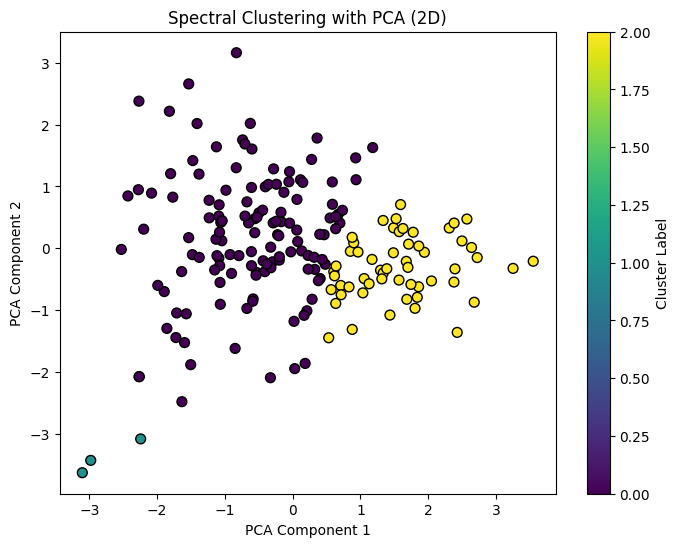

Spectral Clustering Silhouette Score: 0.3638807149150595
Spectral Clustering Davies-Bouldin Index: 0.6920180610405037


In [139]:
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Step 1: Preprocess the data (Scaling, Imputation, Outlier Removal)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(agg_df[features])  # Replace with your features

# Step 2: Remove outliers using Z-score
z_scores = np.abs(zscore(scaled_features))
scaled_features_no_outliers = scaled_features[(z_scores < 3).all(axis=1)]  # Remove outliers

# Step 3: Dimensionality Reduction using PCA
pca = PCA(n_components=2)  # Reducing the data to 2 dimensions for visualization
pca_components = pca.fit_transform(scaled_features_no_outliers)

# Step 4: Apply Spectral Clustering with tuned parameters
n_clusters = 3  # Optimal number of clusters based on previous tuning
spectral = SpectralClustering(n_clusters=n_clusters,
                              affinity='rbf',
                              n_neighbors=15,
                              gamma=1,
                              random_state=42,
                              assign_labels='kmeans')
spectral_labels = spectral.fit_predict(pca_components)

# Step 5: Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=spectral_labels, cmap='viridis', edgecolor='k', s=50)
plt.title('Spectral Clustering with PCA (2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Step 6: Evaluate Clustering (Silhouette Score and DBI)
sil_score = silhouette_score(pca_components, spectral_labels)
db_index = davies_bouldin_score(pca_components, spectral_labels)

print(f"Spectral Clustering Silhouette Score: {sil_score}")
print(f"Spectral Clustering Davies-Bouldin Index: {db_index}")


# AGGLOMERATIVE CLUSTERING

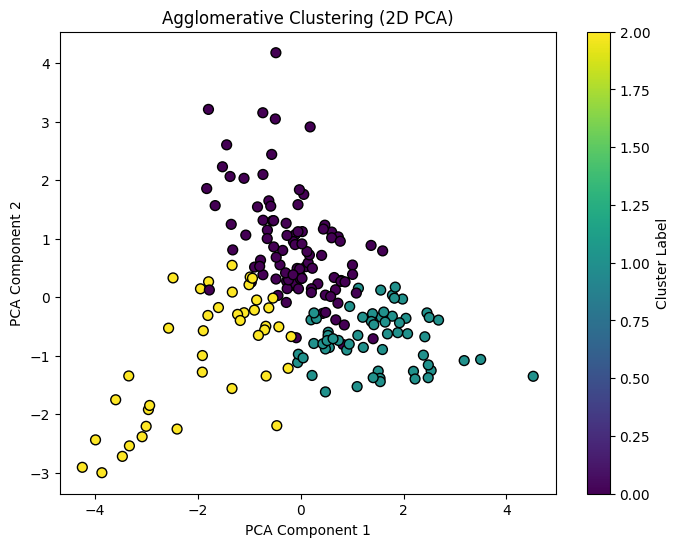

Agglomerative Clustering - Silhouette Score: 0.22715049885444208
Agglomerative Clustering - Davies-Bouldin Index: 1.391865690815676


In [85]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Preprocess the features
features = ['total_spent', 'avg_transaction_value', 'num_transactions', 'transaction_frequency', 'recency']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(agg_df[features])

# Step 2: Apply Agglomerative Clustering
n_clusters = 3  # You can experiment with different values for n_clusters
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
agg_df['Agglomerative_Cluster'] = agg_clustering.fit_predict(scaled_features)

# Step 3: Reduce Dimensions to 2 or 3 using PCA for visualization
pca = PCA(n_components=2)  # Change to n_components=3 for 3D plot
pca_components = pca.fit_transform(scaled_features)

# Step 4: Plot the Clusters (2D visualization)
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=agg_df['Agglomerative_Cluster'], cmap='viridis', edgecolor='k', s=50)
plt.title('Agglomerative Clustering (2D PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Step 5: Calculate the Silhouette Score and Davies-Bouldin Index (DBI)
sil_score = silhouette_score(scaled_features, agg_df['Agglomerative_Cluster'])
db_index = davies_bouldin_score(scaled_features, agg_df['Agglomerative_Cluster'])

# Print the scores
print(f'Agglomerative Clustering - Silhouette Score: {sil_score}')
print(f'Agglomerative Clustering - Davies-Bouldin Index: {db_index}')
